In [ ]:
!pip install -r https://raw.githubusercontent.com/datamllab/automl-in-action-notebooks/master/requirements.txt

In [ ]:
import tensorflow as tf
import autokeras as ak

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[-1], 'GPU')

## Load Cifar10 dataset

In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('Training image shape:', x_train.shape) # (60000, 28, 28)
print('Training label shape:', y_train.shape) # (60000,)
print('First five training labels:', y_train[:5]) # array([5 0 4 1 9], dtype=uint8)

Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
First five training labels: [[6]
 [9]
 [9]
 [4]
 [1]]


In [ ]:
airplane_automobile_indices_train = (y_train[:, 0]==0) | (y_train[:, 0]==1)
airplane_automobile_indices_test = (y_test[:, 0]==0) | (y_test[:, 0]==1)
x_train, y_train = x_train[airplane_automobile_indices_train], y_train[airplane_automobile_indices_train]
x_test, y_test = x_test[airplane_automobile_indices_test], y_test[airplane_automobile_indices_test]
print('Training image shape:', x_train.shape) # (60000, 28, 28)
print('Training label shape:', y_train.shape) # (60000,)
print('First five training labels:', y_train[:5]) # array([5 0 4 1 9], dtype=uint8)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
First five training labels: [[1]
 [1]
 [0]
 [0]
 [1]]


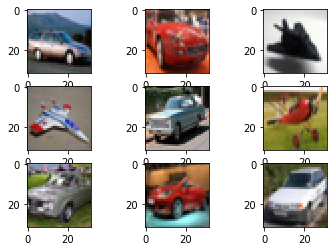

In [ ]:
# plot first few images
from matplotlib import pyplot as plt
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i])
# show the figure
plt.show()

## Jointly selecting image augmentation and normalization methods for ResNet models (ImageBlock)

In [ ]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ImageAugmentation()(output_node)  # horizontal_flip=False
output_node = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=10)
clf.fit(x_train, y_train, epochs=10)

Trial 10 Complete [00h 01m 43s]
val_loss: 0.17701390385627747

Best val_loss So Far: 0.17701390385627747
Total elapsed time: 00h 21m 24s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
313/313 [==============================] - 9s 29ms/step - loss: 0.3964 - accuracy: 0.8342
Epoch 2/10
313/313 [==============================] - 9s 29ms/step - loss: 0.2608 - accuracy: 0.8933
Epoch 3/10
313/313 [==============================] - 10s 32ms/step - loss: 0.1992 - accuracy: 0.9205
Epoch 4/10
313/313 [==============================] - 9s 29ms/step - loss: 0.1698 - accuracy: 0.9349
Epoch 5/10
313/313 [==============================] - 9s 29ms/step - loss: 0.2073 - accuracy: 0.9174
Epoch 6/10
313/313 [==============================] - 9s 29ms/step - loss: 0.1347 - accuracy: 0.9496
Epoch 7/10
313/313 [==============================] - 10s 31ms/step - loss: 0.1238 - accuracy: 0.9544
Epoch 8/10
313/313 [==============================] - 9s 30ms/step - loss: 0.1054 - accuracy: 0.9611
Epoch 9/10
313/

In [ ]:
import autokeras as ak
import timeit

input_node = ak.ImageInput()
output_node = ak.ImageBlock(
                # do not specify if we want to use normalization and let it to search automatically
                normlize=None,
                # do not specify if we want to use adata ugmentation method and let it to search automatically
                augment=None,
                # Only search resnet architectures.
                block_type="resnet")(input_node)
output_node = ak.ClassificationHead(dropout=0.0)(output_node)

auto_model = ak.AutoModel(
    inputs=input_node, 
    outputs=output_node,
    max_trials=10,
    overwrite=True,
    seed=42)

start_time = timeit.default_timer()
auto_model.fit(x_train, y_train, epochs=10, batch_size=64)
stop_time = timeit.default_timer()
print('Total time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))

In [ ]:
auto_model.tuner.results_summary()

In [ ]:
best_model = auto_model.export_model()
best_model.summary()

In [ ]:
test_loss, test_acc = auto_model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: {accuracy}%'.format(accuracy=round(test_acc * 100, 2)))